# Autoencoder Compression
### By Angel Villar Corrales

The goal of this notebook is to ilustrate how a Deep Learning Autoencoder can be used to compress and decompress information, even after being sent over a noisy channel.

In [1]:
import keras.backend as K
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, GaussianNoise, Flatten, Reshape, Lambda
from keras.models import Model
from keras.optimizers import Adam
from matplotlib.colors import ListedColormap

Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

[]

## 1. Loading the Data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
training_size = x_train.shape
test_size = x_test.shape
print(f"Training set size: {training_size}\nTest set size: {test_size}")

Training set size: (60000, 28, 28)
Test set size: (10000, 28, 28)


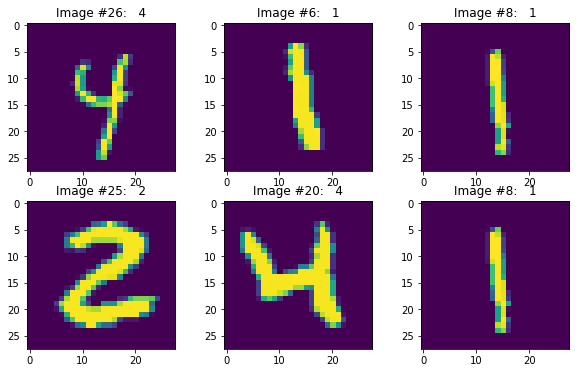

In [4]:
# displaying some samples
random_numbers = np.random.randint(0,training_size[-1],6) 

fig,ax = plt.subplots(2,3)
fig.set_size_inches(10,6)

for i,n in enumerate(random_numbers):
    row = i//3
    col = i%3
    ax[row,col].imshow(x_train[n])
    ax[row,col].set_title(f"Image #{n}:   {y_train[n]}")

# 2. Creating a network
Creating a simple FC network with a default bottleneck dimension of 2

In [5]:
# Method that normalizes the energy of transmited signal
def energy_normalization(x):
    energy = K.sum(K.square(x)) / K.cast(K.shape(x)[0], float)
    norm_x = x / K.sqrt(energy)
    return norm_x

# fully connected network
def fully_connected(bottleneck_dim=2, stddev_noise=0.1, lr=0.1, loss="binary_crossentropy"):
    
    input_img = Input(shape=(28, 28,))

    encoded = Flatten()(input_img)
    encoded = Dense(256, activation='relu')(encoded)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(bottleneck_dim)(encoded)

    channel_input = Lambda(energy_normalization)(encoded)
    channel_output = GaussianNoise(stddev_noise)(channel_input)

    decoded = Dense(64, activation='relu')(channel_output)
    decoded = Dense(256, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)
    decoded = Reshape(target_shape=(28, 28))(decoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, channel_input)

    opt = Adam(lr=lr)
    autoencoder.compile(optimizer=opt, loss=loss)
    
    return autoencoder, encoder

In [6]:
def compute_noise_power( SNR_dB=10 ):
    SNR = 10 ** (SNR_dB / 10)
    noise_power = 1 / (2 * SNR)
    stddev_noise = np.sqrt(noise_power)
    return stddev_noise

SNR_dB = 20
stddev_noise = compute_noise_power(SNR_dB)

autoencoder, encoder = fully_connected(bottleneck_dim=3, stddev_noise=stddev_noise,
                              lr=0.01, loss="binary_crossentropy")

autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

W1127 11:20:05.961501 139684845672256 deprecation.py:323] From /home/angel/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 64us/step - loss: 0.2806 - val_loss: 0.2225
Epoch 2/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.2158 - val_loss: 0.2016
Epoch 3/20
60000/60000 [==============================] - 2s 31us/step - loss: 0.1961 - val_loss: 0.1874
Epoch 4/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.1868 - val_loss: 0.1812
Epoch 5/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.1825 - val_loss: 0.1775
Epoch 6/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.1797 - val_loss: 0.1750
Epoch 7/20
60000/60000 [==============================] - 2s 29us/step - loss: 0.1778 - val_loss: 0.1731
Epoch 8/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.1762 - val_loss: 0.1711
Epoch 9/20
60000/60000 [==============================] - 2s 37us/step - loss: 0.1747 - val_loss: 0.1703
Epoch

# 3. Displaying some Encoded/Decoded digits

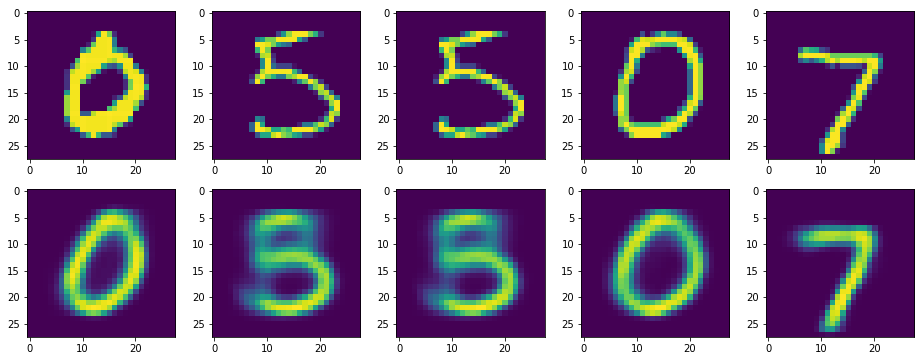

In [7]:
decoded_imgs = autoencoder.predict(x_test)

random_numbers = np.random.randint(0, test_size[-1], 5)

fig, ax = plt.subplots(2,5)
fig.set_size_inches(16,6)

for i,n in enumerate(random_numbers):
    ax[0,i].imshow(x_test[n])
    ax[1,i].imshow(decoded_imgs[n])   
    

# 4. Displaying the latent space

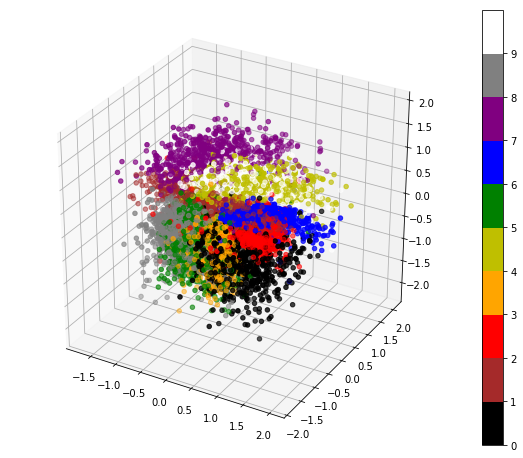

In [8]:
# obtaining the coded data
coded_imgs = encoder.predict(x_test)

cb_labels = [str(i) for i in range(10)]
colors = ['k', 'brown', 'r', 'orange', 'y', 'g', 'b', 'purple', 'grey', 'white']
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection="3d")
im = ax.scatter(coded_imgs[:, 0], coded_imgs[:, 1], coded_imgs[:, 2], c=y_test, cmap=ListedColormap(colors))
cb = fig.colorbar(im)
loc = np.arange(0, max(y_test), max(y_test) / float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(cb_labels)


# 5. Using now a CNN Autoencoder

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Dense, GaussianNoise, Flatten, Reshape, Lambda, UpSampling2D

# convolutional neural network
def cnn(bottleneck_dim=2, stddev_noise=0.1, lr=0.1, loss="binary_crossentropy"):
    
    input_img = Input(shape=(28, 28,1))
    encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    before_flattening_dimension = encoded.shape
    encoded = Flatten()(encoded)
    flatten_dimension = before_flattening_dimension[1]*before_flattening_dimension[2]*before_flattening_dimension[3]
    encoded = Dense(bottleneck_dim)(encoded)
    
    channel_input = Lambda(energy_normalization)(encoded)
    channel_output = GaussianNoise(stddev_noise)(channel_input)

    decoded = Dense(flatten_dimension)(channel_output)
    target_dim = before_flattening_dimension[1:]
    decoded = Reshape(target_dim)(decoded)
    decoded = Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(16, (3, 3), activation='relu')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)
    
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, channel_input)

    opt = Adam(lr=lr)
    autoencoder.compile(optimizer=opt, loss=loss)
    
    return autoencoder, encoder

In [ ]:
SNR_dB = 20
stddev_noise = compute_noise_power(SNR_dB)

autoencoder, encoder = cnn(bottleneck_dim=3, stddev_noise=stddev_noise,
                              lr=0.01, loss="binary_crossentropy")

x_train_extended = x_train[:,:,:,np.newaxis]
x_test_extended = x_test[:,:,:,np.newaxis]

autoencoder.fit(x_train_extended, x_train_extended,
                epochs=20,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_extended, x_test_extended))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 33s 551us/step - loss: 0.2909 - val_loss: 0.2291
Epoch 2/20
60000/60000 [==============================] - 32s 531us/step - loss: 0.2208 - val_loss: 0.2114
Epoch 3/20
60000/60000 [==============================] - 33s 551us/step - loss: 0.2084 - val_loss: 0.2031
Epoch 4/20
60000/60000 [==============================] - 33s 556us/step - loss: 0.2023 - val_loss: 0.1984
Epoch 5/20
60000/60000 [==============================] - 34s 568us/step - loss: 0.1989 - val_loss: 0.1947
Epoch 6/20
60000/60000 [==============================] - 35s 588us/step - loss: 0.1958 - val_loss: 0.1920
Epoch 7/20
60000/60000 [==============================] - 35s 583us/step - loss: 0.1931 - val_loss: 0.1895
Epoch 8/20
60000/60000 [==============================] - 35s 589us/step - loss: 0.1909 - val_loss: 0.1882
Epoch 9/20
33792/60000 [===============>..............] - ETA: 13s - loss: 0.1898